In [1]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import silhouette_score, silhouette_samples
import numpy as np
import torch
import os
import pandas as pd
from sys import path
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
path.append(os.path.realpath('..'))
#mnist = fetch_openml('mnist_784', version=1)
#mnist.target = mnist.target.astype(np.int64)

#X_train, X_test, y_train, y_test = train_test_split(
 #   mnist["data"], mnist["target"], random_state=42)

In [2]:
data_path = "MusicInfo.csv"  # Ajusta la ruta según sea necesario


# Cargar el archivo
df = pd.read_csv(data_path)
X = df.iloc[:, :-1].values   # Todas menos la última columna
y = df.iloc[:, -1].values    # Última columna (la etiqueta)

# 2. Si las etiquetas son texto, conviértelas a enteros
# (Opcional, solo si y son strings)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

# 3. Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [3]:


# Cargar el archivo
data_path = "MusicInfo.csv"
df = pd.read_csv(data_path)

# Detectar las columnas que contienen texto
for col in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# Separar características (X) y etiqueta (y)
X = df.drop(columns=["genre"]).values  # Todas las columnas excepto 'genre'
y = df["genre"].values                 # Solo la columna 'genre' como etiqueta


# 3. Normalizar o estandarizar las características (X)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Escalar las características

# 4. Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42)

# Ahora puedes continuar con el modelo de KMeans u otro algoritmo


In [4]:
silhouette_scores = []

for k in range(2, 35):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_train)
    score = silhouette_score(X_train, labels)
    silhouette_scores.append(score)
    

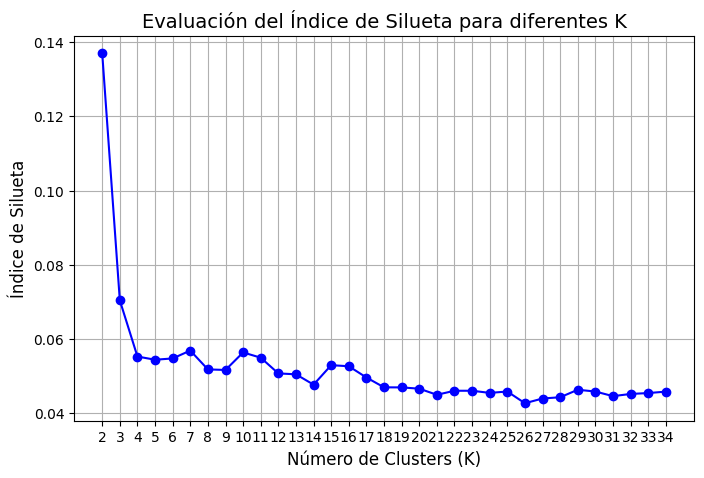

In [5]:
plt.figure(figsize=(8, 5))
plt.plot(range(2, 35), silhouette_scores, 'bo-')
plt.xlabel("Número de Clusters (K)", fontsize=12)
plt.ylabel("Índice de Silueta", fontsize=12)
plt.title("Evaluación del Índice de Silueta para diferentes K", fontsize=14)
plt.grid(True)
plt.xticks(range(2, 35))
plt.show()


In [6]:
from sklearn.cluster import KMeans

k = 10
kmeans = KMeans(n_clusters=k, random_state=42)
X_digits_dist = kmeans.fit_transform(X_train)
clusters = kmeans.fit_predict(X_train)

In [7]:
idxs = np.argmin(X_digits_dist, axis=0)
X_representative_digits = X_train[idxs]  # Sin .values


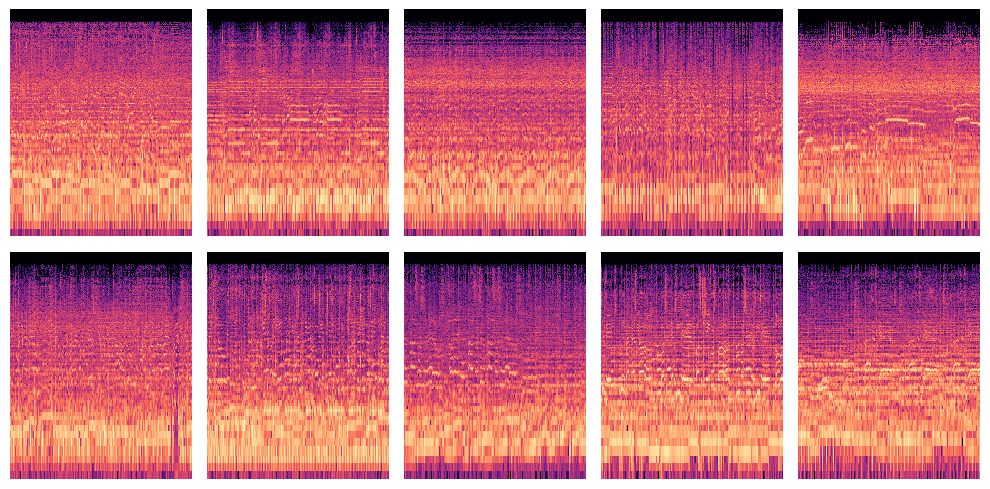

In [9]:
import librosa
import librosa.display
import requests
import matplotlib.pyplot as plt
import numpy as np
import tempfile
from urllib.parse import urlparse
dfa = pd.read_csv("MusicInfo.csv")
# Lista de URLs de los primeros 10 fragmentos de audio (ajusta el número según sea necesario)
audio_urls = dfa['spotify_preview_url'][:10]  # Cambia el número según cuántos fragmentos quieras visualizar

# Crear una figura para mostrar el espectrograma
plt.figure(figsize=(10, 5))

# Filtrar y corregir las URLs que no tienen esquema
for index, url in enumerate(audio_urls):
    # Si la URL no tiene esquema (http:// o https://), agregar https:// por defecto
    if not urlparse(url).scheme:
        url = 'https://' + url
    
    try:
        # Descargar el archivo de audio de la URL
        response = requests.get(url)
        response.raise_for_status()  # Verificar que la respuesta fue exitosa

        # Guardar el archivo temporalmente
        with tempfile.NamedTemporaryFile(delete=False) as tmp_file:
            tmp_file.write(response.content)
            tmp_file_path = tmp_file.name

        # Cargar el audio descargado usando librosa
        y, sr = librosa.load(tmp_file_path, sr=None)

        # Calcular el espectrograma
        D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)

        # Mostrar el espectrograma
        plt.subplot(2, 5, index + 1)  # Organizar en 2 filas y 5 columnas (ajusta según el número de archivos)
        librosa.display.specshow(D, x_axis='time', y_axis='log', sr=sr)
        plt.axis('off')  # No mostrar los ejes

    except requests.exceptions.RequestException as e:
        print(f"Error al descargar el archivo de audio en la URL {url}: {e}")

# Mostrar la figura
plt.tight_layout()
plt.show()


In [10]:
#y_representative_digits = y_train[idxs]

In [13]:

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

generos = []
for i, idx in enumerate(idxs):
    print(f"\nCluster {i}")
    print(f"Vector de características representativo: {X_train[idx]}")
    genero = input(f"Ingrese el género musical para el cluster {i}: ")
    generos.append(genero)

# --- 9. Convertir géneros a valores numéricos ---
le_generos = LabelEncoder()
y_representative = le_generos.fit_transform(generos)

# --- 10. Propagar etiquetas a todo el conjunto de entrenamiento ---
y_train_propagated = np.empty(len(X_train), dtype=int)
for i in range(k):
    y_train_propagated[clusters == i] = y_representative[i]

# --- 11. Clasificador supervisado entrenado con etiquetas propagadas ---
clf = LogisticRegression(max_iter=5000, random_state=42)
clf.fit(X_train, y_train_propagated)

# --- 12. Evaluar en el conjunto real de test ---
# y_pred = clf.predict(X_test)
# print("\nReporte de clasificación (predicciones usando clusters):")
# print(classification_report(y_test, y_pred, target_names=le_generos.classes_))

print("Etiquetas de género asociadas a los clusters (en orden):")
for i, label in enumerate(le_generos.classes_):
    print(f"{i}: {label}")


print("\nGéneros asignados por cluster:")
for i in range(k):
    print(f"Cluster {i}: {generos[i]}")



Cluster 0
Vector de características representativo: [ 0.18597598 -0.50400105 -0.55150108 -0.20168944  0.21948421  0.50650018
 -3.38792758 -0.66944441  0.15915793 -0.93916252  0.47287892 -1.28922241
  0.76461498 -0.2647494   0.27800429  0.12377139  0.21968798 -0.63426805
 -0.05454546  0.24269015]

Cluster 1
Vector de características representativo: [ 0.67343672 -0.20128602 -0.24364603 -0.93358961 -0.04274098 -0.03803136
 -0.00195521 -0.73476027 -0.02536826 -1.30055226 -0.36791821 -0.65822021
  0.76461498 -0.61208744  1.68796457 -0.66840546 -0.6444407   0.25452862
 -0.5850167   0.24269015]

Cluster 2
Vector de características representativo: [ 0.16485632 -0.32998604  0.53606162 -0.59583691 -0.1880039   0.19671612
  0.33664202 -0.2131257  -0.78024809  1.04252404 -0.36791821  1.07714579
  0.76461498  0.13258428 -0.70585872 -0.66736406 -0.16473017 -0.68836872
  1.16841138  0.24269015]

Cluster 3
Vector de características representativo: [-7.22100775e-01 -2.54050978e-01  7.28419649e-01 -1.2

In [ ]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
%time log_reg.fit(X_train[:500], y_train[:500])
log_reg.score(X_test, y_test)

CPU times: total: 31.2 ms
Wall time: 34.1 ms


c:\Users\antra\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


0.4552628982933807